# 3 Row Steady CFD Comparison

This example comes from Aerodynamic Solutions example directory. The example is of a 3 Row Turbine (stator-rotor-stator). Simulation results are in the CFD Directory.  I highly encourage you to check out their code [here](https://new.aerodynamic-solutions.com).

In this example Turbo-Design solution was compared with the 3D CFD Solution to determine calculation accuracy. Total Pressure loss from CFD was prescribed and massflow, power, and efficiency was compared. 

Ideally, we would use CFD to generate data and that data can be converted to loss models using machine learning or curve fitting. Loss models can then be used with turbo-design to rapidly iterate through different designs or even pair it with cycle modeling tools. 

## Turbo Design Setup

In [ ]:
!pip install -U turbo-design

In [1]:
'''
    1D meanline example from 
    Turbine Passage Design Methodology to Minimize Entropy Production—A Two-Step Optimization Strategy. 
    https://doi.org/10.3390/e21060604 
    
    In this example the blade exit angles are fixed and only degree of reaction changes between the stage to match the massflow
'''
#%% Import Library
from turbodesign import PassageType
from turbodesign import TurbineSpool, Inlet, RowType, BladeRow, Passage, Outlet
from turbodesign.enums import MassflowConstraint
from turbodesign.coolant import Coolant
from turbodesign.loss.turbine import FixedPressureLoss
from pyturbo.helper import line2D
import numpy as np 
from cantera import Solution


### Create the Passage
The code below creates the passage curves for the hub and shroud. The blade is then positioned axially. 

In [3]:
# Design the hub and shroud curves 
hub_shroud = np.array([[-3, 6, -3, 7.5],
                       [ 7, 6,  7, 7.5]]) * 0.0254
hub = hub_shroud[:,:2]
shroud = hub_shroud[:,2:]
# Location of each of the rows 
row1X = np.array([[-2.5, 6, -2.5, 7.5],[0.358, 6, 0.358, 7.5]]) * 0.0254 # Inch to meter
row2X = np.array([[0.358, 6, 0.358, 8],[2.68, 6, 2.68, 7.5]]) * 0.0254 
row3X = np.array([[2.68, 6, 2.68, 7.5], [6, 4, 6, 7.5]]) * 0.0254 
axial_len = row3X[-1,0] - row1X[0,0]
cax1 = row1X[-1,0]-row1X[0,0] # Calculate the axial chord
cax2 = row2X[-1,0]-row2X[0,0]
cax3 = row3X[-1,0]-row3X[0,0]

hub = line2D(hub[0,:],hub[1,:])
xhub,rhub = hub.get_point(np.linspace(0,1,100))

shroud = line2D(shroud[0,:],shroud[1,:])
xshroud,rshroud = shroud.get_point(np.linspace(0,1,100))


passage = Passage(xhub.flatten(),rhub.flatten(),
                 xshroud.flatten(),rshroud.flatten(),
                 passageType=PassageType.Axial)

In [5]:
#%% Design Conditions 
Design_RPM = -9000
massflow =9    # kg/s, Initial guess
P0 = 413.617*1000    # Pascal 
T0 = 555.5        # Kelvin

# Fluid
air = Solution('air.yaml')
air.TP = T0, P0 # Use pascal for cantera
print(f"Coefficient of Pressure [J/Kg] {air.cp:0.4f}")


Coefficient of Pressure [J/Kg] 1040.7153


In [6]:
inlet = Inlet(M=0.02, 
                 P0=[P0],
                 T0=[T0], 
                 beta=[0],
                 percent_radii=0.5,
                 location=0)

outlet = Outlet(P=206.799*1000,percent_radii=0.5,num_streamlines=5)

#%% Define Blade Rows 
# Axial location is a percentage along the hub where row exit is defined
stator1 = BladeRow(row_type=RowType.Stator,location=cax1/axial_len)
rotor1 = BladeRow(row_type=RowType.Rotor, location=(cax1+cax2)/axial_len)
stator2 = BladeRow(row_type=RowType.Stator,location=1)

In [7]:
stator1.axial_chord = cax1 # Set an axial chord
rotor1.axial_chord = cax2
stator2.axial_chord = cax3 

stator1.stage_id = 0; rotor1.stage_id = 0
stator2.stage_id = 0; 

# Coolant Definition: Use Kelvin and Pascal. Coolant only needs P0, T0, massflow, and Cp
stator1.coolant = Coolant(T0=T0*0.5, P0 = P0 * 6894.76, massflow_percentage=0, Cp=air.cp) 
rotor1.coolant = Coolant(T0*0.5, P0 = P0 * 6894.76, massflow_percentage=0, Cp=air.cp)
stator2.coolant = Coolant(T0=T0*0.5, P0 = P0 * 6894.76, massflow_percentage=0, Cp=air.cp) 

# Add in turning angles
stator1.beta2_metal = [-67.1,-67.1,-67.1,-67.1,-67.1]                  # Alpha2
# Including beta1_metal angles could be useful for loss calculations if the custom loss function uses inlet metal angle
rotor1.beta1_metal = [-30,-30,-30,-30,-30]              # Beta2
rotor1.beta2_metal = [62.7,62.7,62.7,62.7,62.7]         # Beta25

stator2.beta2_metal = [-65.1,-65.1,-65.1,-65.1,-65.1]   # Alpha3

# These are all guessed values 
stator1.loss_model = FixedPressureLoss(0.048)
rotor1.loss_model = FixedPressureLoss(0.108)
stator2.loss_model = FixedPressureLoss(0.082)
stator1.inlet_to_outlet_pratio = (0.1,0.95)
rotor1.inlet_to_outlet_pratio = (0.1,0.95)
stator2.inlet_to_outlet_pratio = (0.1,0.95)

#%% Initialize the Spool
spool = TurbineSpool(passage=passage,
            rpm=Design_RPM, 
            num_streamlines=5, 
            massflow=massflow, 
            fluid=air,
            rows=[inlet,stator1,rotor1,stator2,outlet])
spool.massflow_constraint = MassflowConstraint.BalanceMassFlow # Fixes the exit angle and changes degree of reaction
# spool.plot_geometry()
spool.solve() # This also initializes streamlines
spool.export_properties("3RowSteady.json")

/Users/pjuangph/Documents/GitHub/turbo-design/turbodesign/passage.py:122: RuntimeWarning: divide by zero encountered in divide
  radius_curvature[indices[0]:indices[-1]] = np.divide(radius_curvature[indices[0]:indices[-1]], np.abs(d2r_dx2))
/Users/pjuangph/Documents/GitHub/turbo-design/turbodesign/radeq.py:102: RuntimeWarning: divide by zero encountered in divide
  eqn15_rhs = Vt**2/r - Vm**2/rm*np.cos(phi) - Vr*dVm_dm # right hand side of equation 15
/opt/homebrew/Caskroom/miniconda/base/envs/dev/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Looping to converge massflow
[0.525 0.525]
high massflow deviation detected
[0.526 0.525]
high massflow deviation detected
[0.525 0.526]
high massflow deviation detected
[0.1 0.1]
high massflow deviation detected
[0.39170973 0.39170973]
[0.39270973 0.39170973]
[0.39170973 0.39270973]
[0.1 0.1]
high massflow deviation detected
[0.32195479 0.32195479]
[0.32295479 0.32195479]
[0.32195479 0.32295479]
[0.1        0.81947539]
high massflow deviation detected
[0.29975931 0.37170685]
[0.31774196 0.33139803]
[0.31874196 0.33139803]
[0.31774196 0.33239803]
[0.45472189 0.45918554]
high massflow deviation detected
[0.36425627 0.37479087]
[0.36525627 0.37479087]
[0.36425627 0.37579087]
[0.34378152 0.35017427]
[0.34478152 0.35017427]
[0.34378152 0.35117427]
[0.35485836 0.36075288]
[0.3490296  0.35518629]
[0.3500296  0.35518629]
[0.3490296  0.35618629]
[0.34565322 0.35358907]
[0.3481161  0.35475416]
[0.34875763 0.35505763]
[0.34892098 0.35513491]
[0.34992098 0.35513491]
[0.34892098 0.35613491]
[0.348

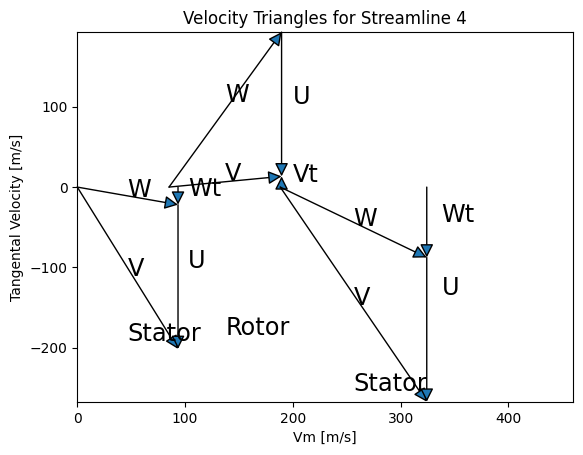

In [8]:
spool.plot_velocity_triangles()

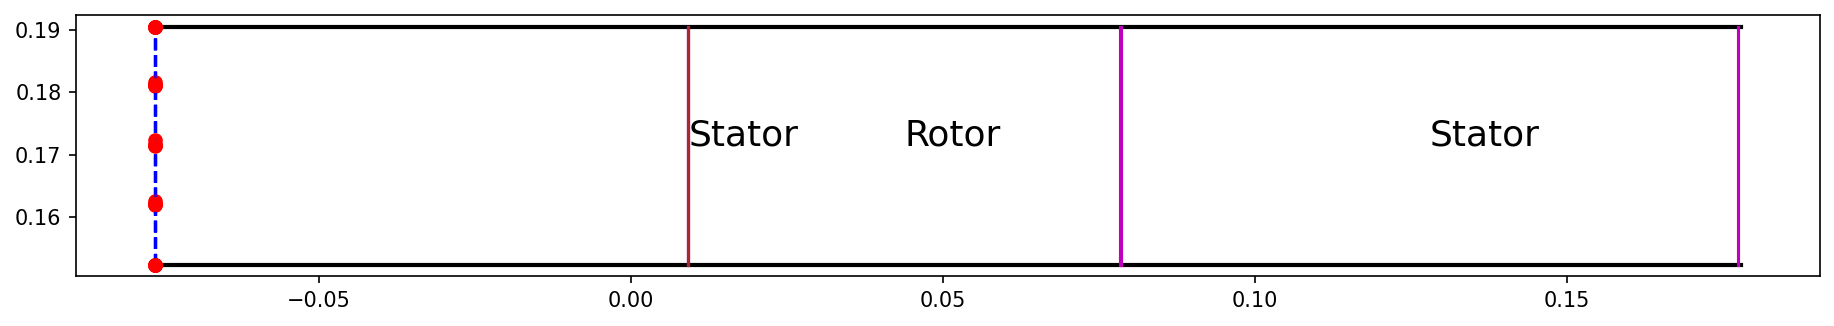

In [9]:
# This plots the hub and shroud curves and the blade exit locations. 
spool.plot()